## Setup

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 14.8MB/s 
     |████████████████████████████████| 194kB 54.9MB/s 
     |████████████████████████████████| 1.2MB 53.5MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 12.8MB 230kB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [3]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

## Exploring the data set

In [5]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [6]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0


## Pixel Similarity

In [7]:
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]
len(three_tensors), len(seven_tensors)

(6131, 6265)

In [8]:
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

In [9]:
mean3 = stacked_threes.mean(0)
mean7 = stacked_sevens.mean(0)

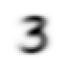

In [10]:
show_image(mean3)

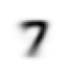

In [11]:
show_image(mean7)

In [12]:
a_3 = stacked_threes[1]
def dist_abs(a,b): return (a-b).abs().mean()
def dist_rmse(a,b): return ((a-b)**2).mean().sqrt()
print(dist_abs(a_3, mean3))
print(dist_abs(a_3, mean7))
print(dist_rmse(a_3, mean3))
print(dist_rmse(a_3, mean7))

tensor(0.1114)
tensor(0.1586)
tensor(0.2021)
tensor(0.3021)


In [13]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

In [14]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))

def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [15]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [16]:
acc_3 = is_3(valid_3_tens).float().mean()
acc_7 = (1 - is_3(valid_7_tens).float()).mean()
acc_3, acc_7

(tensor(0.9168), tensor(0.9854))

## Gradient Descent

In [17]:
def f(x): return x**2

In [18]:
xt = tensor(3.).requires_grad_()
yt = f(xt)
yt.backward()
yt, xt.grad

(tensor(9., grad_fn=<PowBackward0>), tensor(6.))

In [19]:
def f(x): return (x**2).sum()
xt = tensor([1., 2., 3.]).requires_grad_()
yt = f(xt)
yt.backward()
yt, xt.grad

(tensor(14., grad_fn=<SumBackward0>), tensor([2., 4., 6.]))

## End to End Gradient Descent Example

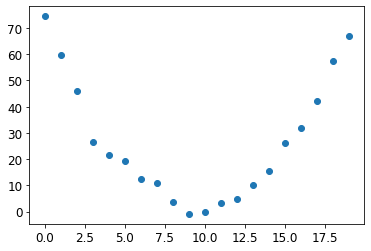

In [20]:
time = torch.arange(20).float()
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time, speed)

In [21]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + b*t + c

In [22]:
def mse(preds, target): return ((preds-target)**2).mean()

In [23]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

In [24]:
params = torch.randn(3).requires_grad_()
lr = 1e-5
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

In [25]:
for i in range(10): apply_step(params)

25823.80859375
5435.53564453125
1577.44921875
847.3778076171875
709.2225341796875
683.0758056640625
678.1243896484375
677.1838989257812
677.0023803710938
676.9645385742188


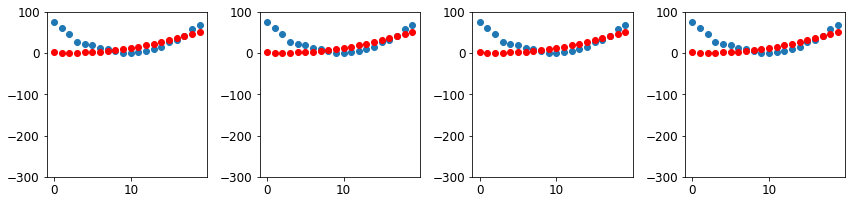

In [26]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

## MNIST Loss Function

In [27]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
dset = list(zip(train_x, train_y))
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [28]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [29]:
x,y = dset[0]
x.shape, y.shape

(torch.Size([784]), torch.Size([1]))

In [30]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [31]:
weights = init_params((28*28,1))
bias = init_params(1)

In [32]:
def linear1(xb): return xb@weights + bias

In [33]:
preds = linear1(train_x)

In [34]:
corrects = (preds>0.0).float() == train_y
corrects.float().mean().item()

0.4912068545818329

In [35]:
weights[0] *= 1.0001
preds = linear1(train_x)
corrects = (preds>0.0).float() == train_y
corrects.float().mean().item()

0.4912068545818329

In [36]:
## creating a loss function
targts = tensor([1, 0, 1])
prds = tensor([0.9, 0.4, 0.2])

In [37]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

## Putting it all together

In [38]:
def init_parameters(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [39]:
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

In [40]:
def linear1(xb): return xb@weights + bias

In [41]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [42]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [43]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= lr * p.grad.data
            p.grad.zero_()

In [44]:
def batch_accuracy(preds, yb):
    preds = preds.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [45]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [46]:
lr = 1
weights = init_parameters((28*28,1))
bias = init_parameters(1)
params = weights, bias

In [47]:
for i in range(25):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.6601 0.8588 0.9198 0.9389 0.9496 0.9574 0.9619 0.9658 0.9667 0.9682 0.9697 0.9702 0.9706 0.9716 0.9721 0.9716 0.9716 0.9721 0.9721 0.9721 0.9726 0.9736 0.9741 0.9741 0.9755 

## Creating an Optimizer

In [48]:
linear_model = nn.Linear(28*28,1)

In [49]:
class BasicOptim:

    def __init__(self, params, lr):
        self.params, self.lr = list(params), lr

    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= self.lr * p.grad.data
    
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

In [50]:
opt = BasicOptim(linear_model.parameters(), lr)

In [51]:
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [52]:
validate_epoch(linear_model)

0.6966

In [53]:
def train_model(model, epoch):
    for i in range(epoch):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [54]:
train_model(linear_model, 25)

0.4932 0.7974 0.8525 0.9165 0.9355 0.9472 0.957 0.9629 0.9658 0.9668 0.9697 0.9712 0.9746 0.9751 0.9761 0.977 0.9775 0.978 0.978 0.9785 0.979 0.979 0.9795 0.979 0.9795 

In [55]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 25)

0.4932 0.8017 0.8511 0.9145 0.9355 0.9487 0.9565 0.9629 0.9658 0.9668 0.9697 0.9721 0.9741 0.9756 0.9761 0.977 0.9775 0.9785 0.9785 0.979 0.979 0.979 0.9795 0.9795 0.98 

In [57]:
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [58]:
learn.fit(25, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636906,0.503421,0.495584,00:00
1,0.496982,0.187504,0.842983,00:00
2,0.183158,0.182067,0.834151,00:00
3,0.080887,0.107829,0.909225,00:00
4,0.043171,0.078633,0.932287,00:00
5,0.028410,0.062906,0.945535,00:00
6,0.022320,0.053116,0.954858,00:00
7,0.019599,0.046606,0.963199,00:00
8,0.018211,0.042043,0.965653,00:00
9,0.017374,0.038695,0.966634,00:00


## Writing a PyTorch Optimizer

In [69]:
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

In [77]:
def mnist_loss(preds, target):
    preds = preds.sigmoid()
    return torch.where(target==1, 1-preds, preds).mean()

In [78]:
class BasicOptim:

    def __init__(self, params, lr):
        self.params, self.lr = list(params), lr

    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= self.lr * p.grad.data
    
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

In [79]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [80]:
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [81]:
def batch_accuracy(preds, yb):
    preds = preds.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()
    
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [82]:
def train_model(model, epoch):
    for i in range(epoch):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [83]:
linear_model = nn.Linear(28*28,1)
lr = 1
opt = BasicOptim(linear_model.parameters(), lr)
train_model(linear_model, 25)

0.4932 0.7832 0.854 0.917 0.935 0.9487 0.9565 0.9629 0.9653 0.9682 0.9697 0.9721 0.9736 0.9746 0.9761 0.977 0.9775 0.9775 0.978 0.9785 0.979 0.979 0.9795 0.979 0.9795 

## Introducing non-Linearity

In [84]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [85]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [86]:
learn.fit(40,0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.304452,0.402783,0.507360,00:00
1,0.141017,0.222214,0.814524,00:00
2,0.078644,0.112358,0.917566,00:00
3,0.052152,0.076381,0.943572,00:00
4,0.039854,0.059901,0.958783,00:00
5,0.033549,0.050647,0.964671,00:00
6,0.029907,0.044796,0.966143,00:00
7,0.027523,0.040791,0.967615,00:00
8,0.025793,0.037872,0.968597,00:00
9,0.024444,0.035639,0.969578,00:00


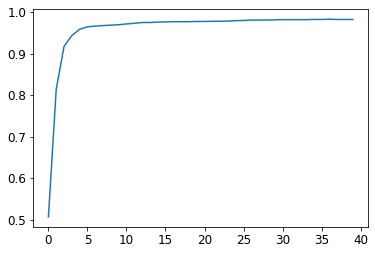

In [87]:
plt.plot(L(learn.recorder.values).itemgot(2))

In [88]:
learn.model

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [89]:
learn.recorder.values[-1][2]

0.98233562707901

## Using ResNet18 and FastAI ToolKit

In [90]:
dls = ImageDataLoaders.from_folder(path)

In [91]:
learn = cnn_learner(dls, resnet18, pretrained=False, loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.183655,0.044168,0.993621,00:15
